## 1. Import thư viện và khởi tạo

In [1]:
import os
from googleapiclient.discovery import build
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Đã import thành công các thư viện!")

✓ Đã import thành công các thư viện!


In [2]:
load_dotenv()

YOUTUBE_API_KEY = os.getenv('YOUTUBE_DATA_API_KEY')
if not YOUTUBE_API_KEY:
    raise ValueError("YOUTUBE_DATA_API_KEY không tìm thấy trong file .env")

youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)
print("✓ Đã khởi tạo YouTube API thành công!")

✓ Đã khởi tạo YouTube API thành công!


## 2. Định nghĩa các hàm crawl dữ liệu

In [ ]:
def search_videos(youtube, keyword, max_pages=5, results_per_page=50):
    videos = []
    page_token = None
    page_count = 0
    
    print(f"\n{'='*60}")
    print(f"🔍 Tìm kiếm video với từ khóa: '{keyword}'")
    print(f"{'='*60}")
    
    while page_count < max_pages:
        try:
            search_response = youtube.search().list(
                q=keyword,
                part='id,snippet',
                maxResults=results_per_page,
                type='video',
                order='relevance',
                pageToken=page_token
            ).execute()
            
            for item in search_response.get('items', []):
                video_info = {
                    'keyword': keyword,
                    'video_id': item['id']['videoId'],
                    'title': item['snippet']['title'],
                    'channel_title': item['snippet']['channelTitle'],
                    'channel_id': item['snippet']['channelId'],
                    'published_at': item['snippet']['publishedAt'],
                    'description': item['snippet']['description']
                }
                videos.append(video_info)
            
            page_count += 1
            print(f"  ✓ Trang {page_count}/{max_pages}: {len(search_response.get('items', []))} videos")
            
            # Kiểm tra xem còn trang tiếp theo không
            page_token = search_response.get('nextPageToken')
            if not page_token:
                print(f"  ⚠ Không còn trang tiếp theo (chỉ có {page_count} trang)")
                break
                
        except Exception as e:
            print(f"  ✗ Lỗi tại trang {page_count + 1}: {str(e)}")
            break
    
    print(f"\n  → Tổng cộng: {len(videos)} videos")
    return videos

In [ ]:
def get_video_comments(youtube, video_id, max_results=100):
    comments = []
    
    try:
        request = youtube.commentThreads().list(
            part='snippet,replies',
            videoId=video_id,
            maxResults=max_results,
            textFormat='plainText'
        )
        
        while request:
            response = request.execute()
            
            for item in response['items']:
                # Top-level comment
                top_comment = item['snippet']['topLevelComment']['snippet']
                comment_data = {
                    'video_id': video_id,
                    'comment_id': item['snippet']['topLevelComment']['id'],
                    'author': top_comment['authorDisplayName'],
                    'text': top_comment['textDisplay'],
                    'like_count': top_comment['likeCount'],
                    'published_at': top_comment['publishedAt'],
                    'updated_at': top_comment['updatedAt'],
                    'is_reply': False,
                    'parent_id': None
                }
                comments.append(comment_data)
                
                # Replies (nếu có)
                if 'replies' in item:
                    for reply in item['replies']['comments']:
                        reply_snippet = reply['snippet']
                        reply_data = {
                            'video_id': video_id,
                            'comment_id': reply['id'],
                            'author': reply_snippet['authorDisplayName'],
                            'text': reply_snippet['textDisplay'],
                            'like_count': reply_snippet['likeCount'],
                            'published_at': reply_snippet['publishedAt'],
                            'updated_at': reply_snippet['updatedAt'],
                            'is_reply': True,
                            'parent_id': item['snippet']['topLevelComment']['id']
                        }
                        comments.append(reply_data)
            
            # Lấy trang tiếp theo nếu có
            if 'nextPageToken' in response:
                request = youtube.commentThreads().list(
                    part='snippet,replies',
                    videoId=video_id,
                    maxResults=max_results,
                    pageToken=response['nextPageToken'],
                    textFormat='plainText'
                )
            else:
                break
                
    except Exception as e:
        if 'commentsDisabled' in str(e):
            pass
        else:
            print(f"    ✗ Lỗi: {str(e)[:100]}")
    
    return comments

## 3. Cấu hình từ khóa và crawl

In [ ]:
KEYWORDS = [
    "review điện thoại",
    "review máy ảnh",
    "cktg",
    "ngoại hạng anh",
    "cúp c1 châu âu"
]

MAX_PAGES_PER_KEYWORD = 5  # Số trang crawl cho mỗi từ khóa
RESULTS_PER_PAGE = 50      # Số video mỗi trang
MAX_COMMENTS_PER_VIDEO = 100  # Số comment tối đa mỗi video

for i, kw in enumerate(KEYWORDS, 1):
    print(f"  {i}. {kw}")

  1. review điện thoại
  2. review máy ảnh
  3. cktg
  4. ngoại hạng anh
  5. cúp c1 châu âu


### 3.1. Crawl danh sách videos

In [11]:
all_videos = []

for i, keyword in enumerate(KEYWORDS, 1):
    print(f"\n[{i}/{len(KEYWORDS)}] Từ khóa: '{keyword}'")
    videos = search_videos(youtube, keyword, max_pages=MAX_PAGES_PER_KEYWORD, results_per_page=RESULTS_PER_PAGE)
    all_videos.extend(videos)

print(f"\n{'='*60}")
print(f"HOÀN THÀNH CRAWL VIDEO")
print(f"{'='*60}")
print(f"Tổng số videos: {len(all_videos)}")

# Tạo DataFrame
df_videos = pd.DataFrame(all_videos)
print(f"\nKích thước DataFrame: {df_videos.shape}")
print(f"Các cột: {list(df_videos.columns)}")


[1/5] Từ khóa: 'review điện thoại'

🔍 Tìm kiếm video với từ khóa: 'review điện thoại'
  ✓ Trang 1/5: 50 videos
  ✓ Trang 2/5: 50 videos
  ✓ Trang 3/5: 50 videos
  ✓ Trang 4/5: 50 videos
  ✓ Trang 5/5: 50 videos

  → Tổng cộng: 250 videos

[2/5] Từ khóa: 'review máy ảnh'

🔍 Tìm kiếm video với từ khóa: 'review máy ảnh'
  ✓ Trang 1/5: 50 videos
  ✓ Trang 2/5: 50 videos
  ✓ Trang 3/5: 25 videos
  ⚠ Không còn trang tiếp theo (chỉ có 3 trang)

  → Tổng cộng: 125 videos

[3/5] Từ khóa: 'cktg'

🔍 Tìm kiếm video với từ khóa: 'cktg'
  ✓ Trang 1/5: 50 videos
  ✓ Trang 2/5: 50 videos
  ✓ Trang 3/5: 50 videos
  ✓ Trang 4/5: 50 videos
  ✓ Trang 5/5: 25 videos
  ⚠ Không còn trang tiếp theo (chỉ có 5 trang)

  → Tổng cộng: 225 videos

[4/5] Từ khóa: 'ngoại hạng anh'

🔍 Tìm kiếm video với từ khóa: 'ngoại hạng anh'
  ✓ Trang 1/5: 25 videos
  ⚠ Không còn trang tiếp theo (chỉ có 1 trang)

  → Tổng cộng: 25 videos

[5/5] Từ khóa: 'cúp c1 châu âu'

🔍 Tìm kiếm video với từ khóa: 'cúp c1 châu âu'
  ✓ Trang 1

In [12]:
print("Mẫu dữ liệu video:\n")
df_videos.head(10)

Mẫu dữ liệu video:



,keyword,video_id,title,channel_title,channel_id,published_at,description
0,review điện thoại,cZZTAE_u5cY,"Tư vấn điện thoại: 6 đến 7 triệu mua iPhone, Samsung hay máy Trung Quốc?",Dương Dê,UCvJ8leyn7YWgqmbmw1R5ZVg,2026-01-27T12:15:11Z,"Tư vấn điện thoại: 6 đến 7 triệu mua iPhone, Samsung hay máy Trung Quốc? Tham khảo tại Cellphone..."
1,review điện thoại,qB4MGZ_WlPc,Top điện thoại Flagship đáng mua nhất 2025!,Dương Dê,UCvJ8leyn7YWgqmbmw1R5ZVg,2025-12-20T06:30:27Z,Top điện thoại Flagship đáng mua nhất 2025! Tham khảo tại Hoàng Hà Mobile : https://hoanghamobil...
2,review điện thoại,fVwv5vwf9u0,Tư vấn điện thoại 7-10 triệu: Phân khúc khó chọn nhất Việt Nam?,Vật Vờ Studio,UCEeXA5Tu7n9X5_zkOgGsyww,2026-01-06T11:21:36Z,Tư vấn điện thoại 7-10 triệu: Phân khúc khó chọn nhất Việt Nam? | Vật Vờ Studio ▻ Mua Samsung Ga...
3,review điện thoại,SK4XtpId3sk,Tư vấn điện thoại: Cách mình mua được máy GIÁ CỰC RẺ!,Dương Dê,UCvJ8leyn7YWgqmbmw1R5ZVg,2026-01-30T13:15:09Z,Tư vấn điện thoại: Cách mình mua được máy GIÁ CỰC RẺ! Tham khảo tại Clickbuy ...
4,review điện thoại,wpMlpZtW0xQ,TOP ĐIỆN THOẠI CHÍNH HÃNG 3-12 TRIỆU GIẢM GIÁ SÂU NHẤT ĐỊNH PHẢI MUA!,F.A CHANNEL,UCNgr4g9AqhEWeSKTlyxnrDg,2026-01-15T09:47:38Z,TOP ĐIỆN THOẠI ĐÁNG MUA NHẤT Dưới 2 Triệu: ⁃ Nubia A36: https://s.shopee.vn/BLXEwltX0 ⁃ Nubia A7...
5,review điện thoại,9DrV-v9vJN0,"TOP ĐIỆN THOẠI 2-3 TRIỆU VÔ ĐỊCH PIN 7000MAH, MÀN 120HZ, CẤU HÌNH KHỎE DÙNG LÂU DÀI!",F.A CHANNEL,UCNgr4g9AqhEWeSKTlyxnrDg,2025-12-09T13:40:17Z,TOP ĐIỆN THOẠI ĐÁNG MUA NHẤT Dưới 2 Triệu: ⁃ Nubia A36: https://s.shopee.vn/BLXEwltX0 ⁃ Nubia A7...
6,review điện thoại,A7FrR7efBpM,Điện Thoại 5 - 10 - 15 - 30 Triệu Chụp Ảnh Khác Gì Nhau? (REDMI 15 vs Xiaomi 17 Ultra),Vật Vờ Studio,UCEeXA5Tu7n9X5_zkOgGsyww,2026-01-24T04:58:39Z,Điện Thoại 5 - 10 - 15 - 30 Triệu Chụp Ảnh Khác Gì Nhau? (REDMI 15 vs Xiaomi 17 Ultra) | Vật Vờ ...
7,review điện thoại,63TUAjt1Ef4,TOP Điện Thoại Mình Thích Nhất Trong Năm 2025!,F.A CHANNEL,UCNgr4g9AqhEWeSKTlyxnrDg,2025-12-19T13:01:30Z,Giáng sinh này Oneway tung ưu đãi cực KHỦNG với chương trình “MỪNG GIÁNG SINH - RINH SIÊU SALE” ...
8,review điện thoại,gov5oktbcFA,Tư vấn điện thoại 5 triệu: Nên chọn iPhone cũ hay máy Trung Quốc?,Vật Vờ Studio,UCEeXA5Tu7n9X5_zkOgGsyww,2026-01-04T03:01:01Z,Tư vấn điện thoại 5 triệu: Nên chọn iPhone cũ hay máy Trung Quốc? Mua Meizu Lucky 08: https://s....
9,review điện thoại,dsN3OFVUW5Y,Điện Thoại XIAOMI Thì NÊN MUA và KHÔNG NÊN MUA Dòng Nào Vào Cuối 2025? Lý Do Là Đây!!!,F.A CHANNEL,UCNgr4g9AqhEWeSKTlyxnrDg,2025-12-11T13:42:03Z,TOP ĐIỆN THOẠI ĐÁNG MUA NHẤT Dưới 2 Triệu: ⁃ Nubia A36: https://s.shopee.vn/BLXEwltX0 ⁃ Nubia A7...


### 3.2. Crawl comments cho từng video

In [13]:
all_comments = []
total_videos = len(df_videos)

print(f"Tổng số videos cần crawl: {total_videos}\n")

for i, row in df_videos.iterrows():
    video_id = row['video_id']
    title = row['title'][:50]
    
    if (i + 1) % 10 == 0 or i == 0:
        print(f"\n[{i+1}/{total_videos}] Đang xử lý: {title}...")
    
    comments = get_video_comments(youtube, video_id, max_results=MAX_COMMENTS_PER_VIDEO)
    all_comments.extend(comments)
    
    if (i + 1) % 10 == 0:
        print(f"  → Tổng comments đến giờ: {len(all_comments)}")

print(f"\n{'='*60}")
print(f"{'='*60}")
print(f"Tổng số comments: {len(all_comments)}")

# Tạo DataFrame
df_comments = pd.DataFrame(all_comments)
print(f"\nKích thước DataFrame: {df_comments.shape}")
print(f"Các cột: {list(df_comments.columns)}")

Tổng số videos cần crawl: 650


[1/650] Đang xử lý: Tư vấn điện thoại: 6 đến 7 triệu mua iPhone, Samsu...

[10/650] Đang xử lý: Điện Thoại XIAOMI Thì NÊN MUA và KHÔNG NÊN MUA Dòn...
  → Tổng comments đến giờ: 1006

[20/650] Đang xử lý: Tư vấn điện thoại: dưới 10 triệu mua được Flagship...
  → Tổng comments đến giờ: 1874

[30/650] Đang xử lý: Hối hận vì mua điện thoại cũ trên mạng #shorts...
  → Tổng comments đến giờ: 3458

[40/650] Đang xử lý: Samsung Galaxy A15 ai xài cũng được :)) #samsung #...
  → Tổng comments đến giờ: 4580

[50/650] Đang xử lý: TOP 3 ĐT TẦM TRUNG ĐÁNG MUA NHẤT CUỐI NĂM 2025, ĐÁ...
  → Tổng comments đến giờ: 5673

[60/650] Đang xử lý: Review Honor X7c chiếc điện thoại bền bỉ dẫn đầu #...
  → Tổng comments đến giờ: 6644

[70/650] Đang xử lý: Đánh Giá Xiaomi 17 Ultra: Hãy Chờ Siêu Phẩm Này Về...
  → Tổng comments đến giờ: 7618

[80/650] Đang xử lý: Galaxy A56 còn quanh 7 triệu thì VÔ ĐỊCH tầm giá !...
  → Tổng comments đến giờ: 9354

[90/650] Đang xử lý: Tổng Hợp Rev

In [15]:
print("Mẫu dữ liệu comment:\n")
df_comments.head(10)

Mẫu dữ liệu comment:



,video_id,comment_id,author,text,like_count,published_at,updated_at,is_reply,parent_id
0,cZZTAE_u5cY,UgyMD1Kn7cUJV_Up2Ut4AaABAg,@duongde_official,Tham khảo tại CellphoneS : https://cellphones.com.vn/dien-thoai-xiaomi-redmi-note-15-5g.html?utm...,3,2026-01-27T10:09:35Z,2026-01-27T10:09:35Z,False,NaN
1,cZZTAE_u5cY,Ugz1HWyDQmmEBeggYzt4AaABAg,@longngocvan6733,anh cho em hỏi tầm giá 8 -9 tr thì được iPhone nào ạ,0,2026-01-29T12:22:57Z,2026-01-29T12:22:57Z,False,NaN
2,cZZTAE_u5cY,Ugz1HWyDQmmEBeggYzt4AaABAg.ASZYiazVunMASihwZyfnuA,@Antft212,Toàn máy lỏ thôi khó tư vấn lắm,0,2026-02-02T11:04:39Z,2026-02-02T11:04:39Z,True,Ugz1HWyDQmmEBeggYzt4AaABAg
3,cZZTAE_u5cY,UgzohG2orjeDcKYfj5p4AaABAg,@hoangyen752,A tư vấn cho e con mua cho phụ huynh dùng ổn từ 2 đến 3 năm giá 7 - 8tr với ak\nƯu tiên pin và mượt,0,2026-01-29T08:03:19Z,2026-01-29T08:03:19Z,False,NaN
4,cZZTAE_u5cY,UgxgJn-OZmb-VuMWWEJ4AaABAg,@Ayase-Yasune,Cháu chào chú Dương. Cháu năm nay lớp 9 tích góp đc 3 triệu. Cháu định mua một chiếc điện thoại ...,0,2026-01-29T06:04:26Z,2026-01-29T06:04:26Z,False,NaN
5,cZZTAE_u5cY,UgxgJn-OZmb-VuMWWEJ4AaABAg.ASYsPGkX54jASarL9YGgtd,@VinceUriel-s4e,Thế mua cục gạch đi 3tr mà đòi hỏi nhiều nếu mà có chỉ mỗi redmi not 12tubor cũ thôi,0,2026-01-30T09:52:52Z,2026-01-30T09:52:52Z,True,UgxgJn-OZmb-VuMWWEJ4AaABAg
6,cZZTAE_u5cY,UgxgJn-OZmb-VuMWWEJ4AaABAg.ASYsPGkX54jASd2JtBQs5S,@THANHNGUYEN-hr2gg,Em canh 2/2 xem Shopee live mua Tecno Camon 30s giá hơn 2tr8. Tìm xem reviews về em nó trước khi...,0,2026-01-31T06:16:02Z,2026-01-31T06:16:02Z,True,UgxgJn-OZmb-VuMWWEJ4AaABAg
7,cZZTAE_u5cY,UgyjRlC5KAk8JbeQ-KV4AaABAg,@quocdungtrinh1594,Tks kênh…,0,2026-01-28T17:13:35Z,2026-01-28T17:13:35Z,False,NaN
8,cZZTAE_u5cY,UgxDjAFXT6PG4ZO6B-Z4AaABAg,@vucong5589,a dương ơi h mà mua ip 16 dùng ok ko ạ . em cảm ơn,0,2026-01-28T14:43:32Z,2026-01-28T14:43:32Z,False,NaN
9,cZZTAE_u5cY,UgxDjAFXT6PG4ZO6B-Z4AaABAg.ASXE0M-6cmVAS_3uN_PRTr,@ĐỗAnhTúxom,Chờ tháng 9 ra rồi mua ip18,0,2026-01-29T17:12:55Z,2026-01-29T17:12:55Z,True,UgxDjAFXT6PG4ZO6B-Z4AaABAg


## 4. Phân tích và thống kê dữ liệu

In [16]:
print("THỐNG KÊ TỔNG QUAN")
print("="*60)
print(f"\nVIDEOS:")
print(f"  - Tổng số videos: {len(df_videos)}")
print(f"  - Số channel độc nhất: {df_videos['channel_title'].nunique()}")
print(f"  - Số từ khóa: {df_videos['keyword'].nunique()}")

if len(df_comments) > 0:
    print(f"\nCOMMENTS:")
    print(f"  - Tổng số comments: {len(df_comments)}")
    print(f"  - Comments gốc: {(~df_comments['is_reply']).sum()}")
    print(f"  - Comments trả lời: {df_comments['is_reply'].sum()}")
    print(f"  - Số tác giả độc nhất: {df_comments['author'].nunique()}")
    print(f"  - Trung bình likes/comment: {df_comments['like_count'].mean():.2f}")
    print(f"  - Tổng likes: {df_comments['like_count'].sum()}")
    
    comments_per_video = df_comments.groupby('video_id').size()
    print(f"\nCOMMENTS THEO VIDEO:")
    print(f"  - Trung bình comments/video: {comments_per_video.mean():.2f}")
    print(f"  - Median comments/video: {comments_per_video.median():.0f}")
    print(f"  - Max comments (1 video): {comments_per_video.max()}")
    print(f"  - Min comments (1 video): {comments_per_video.min()}")
else:
    print("\nKhông có comments nào được crawl")

THỐNG KÊ TỔNG QUAN

VIDEOS:
  - Tổng số videos: 650
  - Số channel độc nhất: 175
  - Số từ khóa: 5

COMMENTS:
  - Tổng số comments: 186801
  - Comments gốc: 140581
  - Comments trả lời: 46220
  - Số tác giả độc nhất: 141448
  - Trung bình likes/comment: 11.83
  - Tổng likes: 2209526

COMMENTS THEO VIDEO:
  - Trung bình comments/video: 313.42
  - Median comments/video: 66
  - Max comments (1 video): 83491
  - Min comments (1 video): 1


In [17]:
print("Số lượng videos theo từ khóa:\n")
video_by_keyword = df_videos['keyword'].value_counts()
print(video_by_keyword)

Số lượng videos theo từ khóa:

keyword
review điện thoại    250
cktg                 225
review máy ảnh       125
ngoại hạng anh        25
cúp c1 châu âu        25
Name: count, dtype: int64


## 5. Trực quan hóa dữ liệu

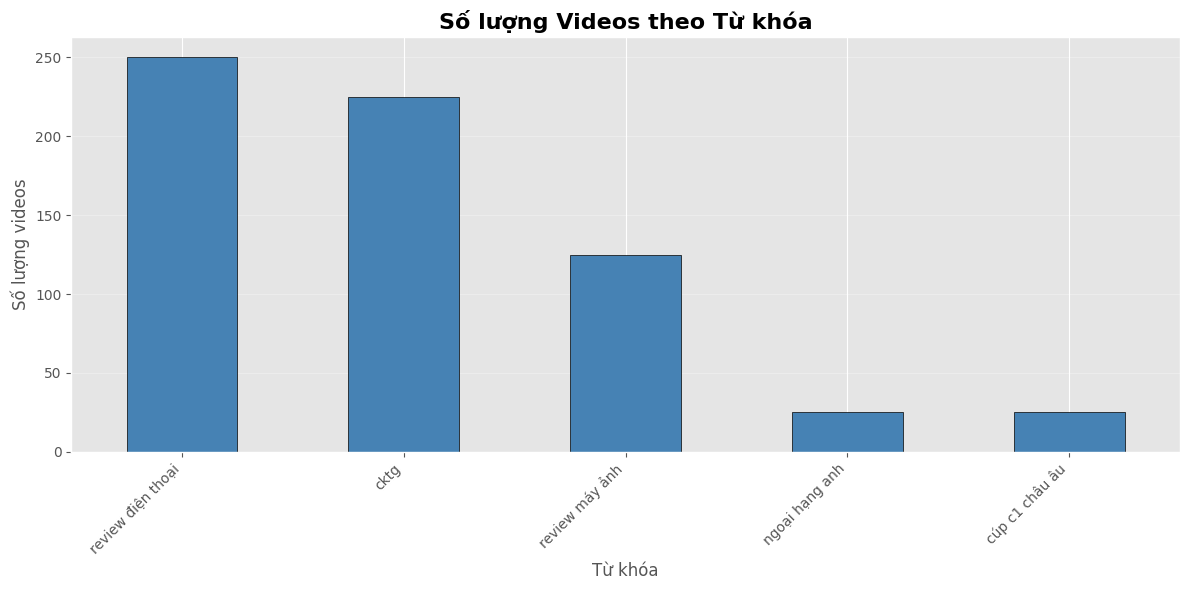

Tổng: 650 videos


In [18]:
plt.figure(figsize=(12, 6))
video_by_keyword.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Số lượng Videos theo Từ khóa', fontsize=16, fontweight='bold')
plt.xlabel('Từ khóa', fontsize=12)
plt.ylabel('Số lượng videos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Tổng: {video_by_keyword.sum()} videos")

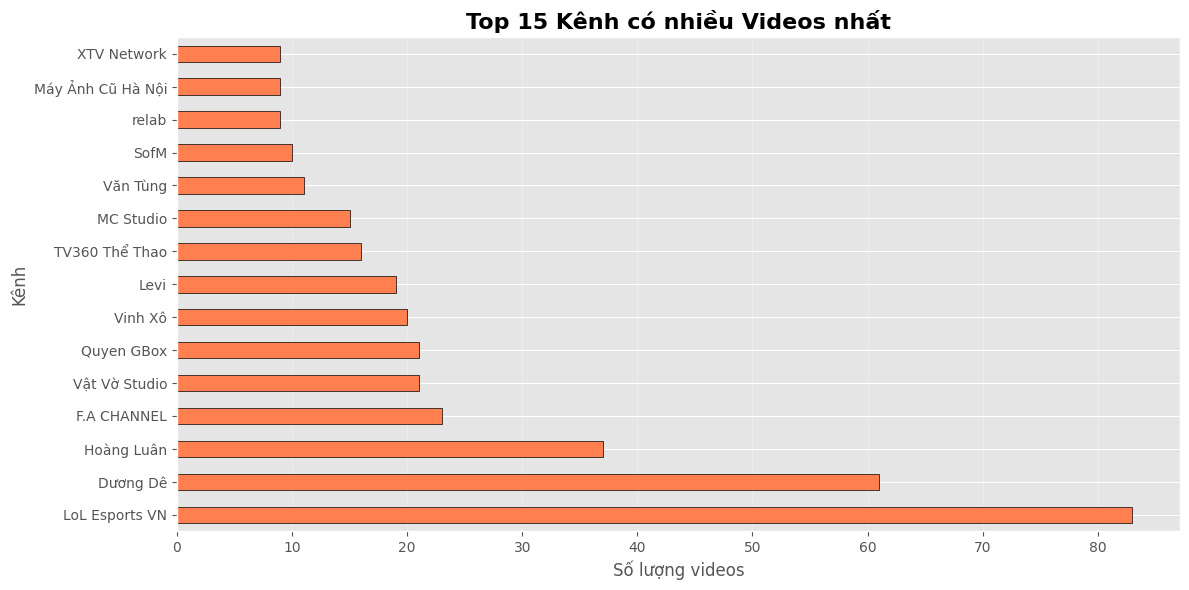

Top 1: LoL Esports VN với 83 videos


In [19]:
plt.figure(figsize=(12, 6))
top_channels = df_videos['channel_title'].value_counts().head(15)
top_channels.plot(kind='barh', color='coral', edgecolor='black')
plt.title('Top 15 Kênh có nhiều Videos nhất', fontsize=16, fontweight='bold')
plt.xlabel('Số lượng videos', fontsize=12)
plt.ylabel('Kênh', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Top 1: {top_channels.index[0]} với {top_channels.iloc[0]} videos")

## 6. Lưu dữ liệu

In [23]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

keywords_str = '_'.join(KEYWORDS[:2]).replace(' ', '_')  # Lấy 2 từ khóa đầu
videos_filename = f'videos_multi_keywords_{timestamp}.csv'
comments_filename = f'comments_multi_keywords_{timestamp}.csv'

df_videos.to_csv(videos_filename, index=False, encoding='utf-8-sig')
print(f"Đã lưu {len(df_videos)} videos vào: {videos_filename}")

if len(df_comments) > 0:
    df_comments.to_csv(comments_filename, index=False, encoding='utf-8-sig')
    print(f"Đã lưu {len(df_comments)} comments vào: {comments_filename}")
else:
    print("Không có comments để lưu")

Đã lưu 650 videos vào: videos_multi_keywords_20260202_214001.csv
Đã lưu 186801 comments vào: comments_multi_keywords_20260202_214001.csv
